In [13]:
import numpy as np
import pandas as pd

In [14]:
# PESI e valori di riferimento (Earth units)
ESI_WEIGHTS = {
    'radius': 0.57,       # R / R_earth
    'density': 1.07,      # rho / rho_earth
    'esc_vel': 0.70,      # Ve / Ve_earth
    'temperature': 5.58   # T (K), Earth ref = 288 K
}
EARTH_TEMP_K = 288.0
EARTH_UNIT = 1.0  # for radius/density/escape (we use Earth units)

In [15]:
def esi_component(value, ref, weight):
    """Calcola il termine (1 - |x-x0|/(x+x0))^weight, robusto ai casi edge."""
    # se manca valore o ref non positivo --> ritorna NaN (va ignorato successivamente)
    if value is None or ref is None or np.isnan(value) or np.isnan(ref):
        return np.nan
    # evitare divisione per zero (se value + ref == 0)
    denom = (abs(value) + abs(ref))
    if denom == 0:
        return np.nan
    base = 1.0 - abs(value - ref) / denom
    # se base è negativa (può succedere per valori estremi) clamp a 0
    base = max(base, 0.0)
    return base ** weight

In [16]:
def compute_escape_velocity_eu(radius_eu, density_eu):
    """
    Approssimazione in Earth units:
    Ve ∝ R * sqrt(density). Con Earth units, Ve_EU = R_EU * sqrt(density_EU).
    Richiede radius e density in Earth units.
    """
    if np.isnan(radius_eu) or np.isnan(density_eu):
        return np.nan
    # se density negativa o radius negativa -> NaN
    if density_eu <= 0 or radius_eu <= 0:
        return np.nan
    return radius_eu * np.sqrt(density_eu)


In [17]:
def compute_ESI_row(row,
                    col_radius='koi_prad',       # es. pl_rade (Earth radii) or koi_prad
                    col_density=None,           # densità relativa (se disponibile) o massa e radius per calcolarla
                    col_temperature='koi_teq'    # equilibrio/temp se disponibile (K)
                   ):
    """
    Calcola ESI per una riga Pandas. Restituisce dict con sotto-indici e ESI globale.
    - col_density: se None, prova a cercare 'pl_dens' o 'koi_density'; altrimenti lascia NaN.
    - Questa funzione non tenta di stimare massa/densità da relazioni massa-raggio.
    """
    out = {}
    comps = {}  # memorizza i componenti non-NaN
    # radius (in Earth radii) -- assumiamo la colonna già in Earth radii
    r = row.get(col_radius, np.nan)
    comps['radius'] = esi_component(r, EARTH_UNIT, ESI_WEIGHTS['radius'])
    # density (in Earth density units) - cerca nomi comuni
    dens = None
    if col_density:
        dens = row.get(col_density, np.nan)
    else:
        # prova colonne tipiche
        for cand in ['pl_dens','pl_rho','koi_density','koi_sdensity']:
            if cand in row.index:
                dens = row.get(cand, np.nan)
                if not (pd.isna(dens)):
                    break
    if not pd.isna(dens):
        comps['density'] = esi_component(dens, EARTH_UNIT, ESI_WEIGHTS['density'])
    else:
        comps['density'] = np.nan

    # escape velocity (calcolata da radius & density, in Earth units)
    ve = compute_escape_velocity_eu(r if not pd.isna(r) else np.nan,
                                    dens if not pd.isna(dens) else np.nan)
    if not pd.isna(ve):
        comps['esc_vel'] = esi_component(ve, EARTH_UNIT, ESI_WEIGHTS['esc_vel'])
    else:
        comps['esc_vel'] = np.nan

    # temperature (pl_eqt in K); Earth ref = 288 K
    T = row.get(col_temperature, np.nan)
    if not pd.isna(T):
        comps['temperature'] = esi_component(T, EARTH_TEMP_K, ESI_WEIGHTS['temperature'])
    else:
        comps['temperature'] = np.nan
    
    # Calcola ESI globale: prendiamo i componenti validi (non-NaN)
    valid = {k: v for k, v in comps.items() if not pd.isna(v)}
    n = len(valid)
    if n == 0:
        esi_global = np.nan
    else:
        # formula: prod_i (component_i)^(1/n)  OR equivalently prod (base)^(w_i/n)
        # qui comps ha già base^w_i, quindi facciamo (prod comps)^(1/n)
        prod = 1.0
        for v in valid.values():
            prod *= v
        esi_global = prod ** (1.0 / n)

    # costruisci output
    out.update(comps)
    out['ESI'] = esi_global
    out['ESI_n_components'] = n
    print(f"Row processed: radius={r}, density={dens}, ve={ve}, temp={T} => ESI={esi_global} with {n} components")
    return out

In [18]:
# Esempio di applicazione su DataFrame df (adatta nomi colonne al tuo df)
def add_ESI_to_df(df, col_radius='pl_rade', col_density=None, col_temperature='pl_eqt'):
    results = df.apply(lambda r: compute_ESI_row(r, col_radius=col_radius,
                                                 col_density=col_density,
                                                 col_temperature=col_temperature), axis=1)
    # results è una serie di dict -> DataFrame
    esi_df = pd.DataFrame(list(results))
    df_with_esi = pd.concat([df.reset_index(drop=True), esi_df.reset_index(drop=True)], axis=1)
    print(f"Computed ESI for {len(df_with_esi)} rows.")
    return df_with_esi

In [19]:
# Load the Kepler dataset
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_csv('KOI_cleaned.csv')
print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset loaded: 7803 rows, 20 columns

Column names:
['kepid', 'kepoi_name', 'koi_disposition', 'koi_score', 'koi_period', 'koi_time0bk', 'koi_impact', 'koi_duration', 'koi_depth', 'koi_prad', 'koi_teq', 'koi_insol', 'koi_model_snr', 'koi_tce_plnt_num', 'koi_steff', 'koi_slogg', 'koi_srad', 'ra', 'dec', 'koi_kepmag']

First few rows:


,kepid,kepoi_name,koi_disposition,koi_score,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_tce_plnt_num,koi_steff,koi_slogg,koi_srad,ra,dec,koi_kepmag
0,10797460,K00752.01,CONFIRMED,1.000,9.488036,170.538750,0.146,2.95750,615.8,2.26,793,93.59,35.8,1,5455,4.467,0.927,291.93423,48.141651,15.347
1,10797460,K00752.02,CONFIRMED,0.969,54.418383,162.513840,0.586,4.50700,874.8,2.83,443,9.11,25.8,2,5455,4.467,0.927,291.93423,48.141651,15.347
2,10811496,K00753.01,CANDIDATE,0.000,19.899140,175.850252,0.969,1.78220,10829.0,14.60,638,39.30,76.3,1,5853,4.544,0.868,297.00482,48.134129,15.436
3,10848459,K00754.01,FALSE POSITIVE,0.000,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395,891.96,505.6,1,5805,4.564,0.791,285.53461,48.285210,15.597
4,10854555,K00755.01,CONFIRMED,1.000,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406,926.16,40.9,1,6031,4.438,1.046,288.75488,48.226200,15.509


In [20]:
# Examine the data structure and key columns for ESI calculation
print("Data types:")
print(df[['koi_prad', 'koi_teq', 'koi_period', 'koi_insol']].dtypes)
print("\nBasic statistics for key columns:")
print(df[['koi_prad', 'koi_teq', 'koi_period', 'koi_insol']].describe())

print("\nMissing values:")
print(df[['koi_prad', 'koi_teq', 'koi_period', 'koi_insol']].isnull().sum())

print(f"\nDispositions distribution:")
print(df['koi_disposition'].value_counts())

Data types:
koi_prad      float64
koi_teq         int64
koi_period    float64
koi_insol     float64
dtype: object

Basic statistics for key columns:
           koi_prad       koi_teq   koi_period     koi_insol
count   7803.000000   7803.000000  7803.000000  7.803000e+03
mean      26.965784   1133.811739    37.314267  7.679770e+03
std      313.055376    832.013752    86.826061  1.679499e+05
min        0.140000     92.000000     0.259820  2.000000e-02
25%        1.410000    610.000000     2.455472  3.263500e+01
50%        2.460000    934.000000     7.698431  1.801400e+02
75%       19.015000   1426.000000    24.089219  9.759750e+02
max    26042.900000  14667.000000  1071.232624  1.094755e+07

Missing values:
koi_prad      0
koi_teq       0
koi_period    0
koi_insol     0
dtype: int64

Dispositions distribution:
koi_disposition
FALSE POSITIVE    3735
CONFIRMED         2712
CANDIDATE         1356
Name: count, dtype: int64


In [21]:
# Calculate ESI for a subset of data first (to avoid too much output)
print("Calculating ESI for first 10 rows as example...")
sample_df = df.head(10).copy()

# Calculate ESI using our function
df_with_esi = add_ESI_to_df(sample_df, col_radius='koi_prad', col_density=None, col_temperature='koi_teq')

# Show results
print("\nESI calculation results (first 10 rows):")
columns_to_show = ['kepoi_name', 'koi_prad', 'koi_teq', 'ESI', 'ESI_n_components', 'radius', 'temperature']
print(df_with_esi[columns_to_show])

Calculating ESI for first 10 rows as example...
Row processed: radius=2.26, density=None, ve=nan, temp=793 => ESI=0.15022132053410692 with 2 components
Row processed: radius=2.83, density=None, ve=nan, temp=443 => ESI=0.4273966809469164 with 2 components
Row processed: radius=14.6, density=None, ve=nan, temp=638 => ESI=0.14807683190558307 with 2 components
Row processed: radius=33.46, density=None, ve=nan, temp=1395 => ESI=0.022308108140526573 with 2 components
Row processed: radius=2.75, density=None, ve=nan, temp=1406 => ESI=0.041219712989622494 with 2 components
Row processed: radius=3.9, density=None, ve=nan, temp=835 => ESI=0.12025603340877812 with 2 components
Row processed: radius=2.77, density=None, ve=nan, temp=1160 => ESI=0.06376328821137518 with 2 components
Row processed: radius=1.59, density=None, ve=nan, temp=1360 => ESI=0.049461950241428874 with 2 components
Row processed: radius=39.21, density=None, ve=nan, temp=1342 => ESI=0.023341762744474807 with 2 components
Row pro

In [22]:
# Calculate ESI for the entire dataset (suppress individual row output)
print("Calculating ESI for entire dataset...")

# Temporarily redirect print to suppress row-by-row output
import sys
from io import StringIO

old_stdout = sys.stdout
sys.stdout = StringIO()

# Calculate ESI for all data
df_full_esi = add_ESI_to_df(df, col_radius='koi_prad', col_density=None, col_temperature='koi_teq')

# Restore stdout
sys.stdout = old_stdout

print(f"ESI calculation completed for {len(df_full_esi)} planets!")
print(f"Planets with valid ESI: {df_full_esi['ESI'].notna().sum()}")
print(f"Average ESI: {df_full_esi['ESI'].mean():.4f}")
print(f"Max ESI: {df_full_esi['ESI'].max():.4f}")
print(f"Min ESI: {df_full_esi['ESI'].min():.4f}")

# Show top 10 planets by ESI
print("\nTop 10 planets by ESI:")
top_esi = df_full_esi.nlargest(10, 'ESI')[['kepoi_name', 'koi_disposition', 'koi_prad', 'koi_teq', 'ESI', 'ESI_n_components']]
print(top_esi)

Calculating ESI for entire dataset...
ESI calculation completed for 7803 planets!
Planets with valid ESI: 7803
Average ESI: 0.1648
Max ESI: 0.9956
Min ESI: 0.0000

Top 10 planets by ESI:
     kepoi_name koi_disposition  koi_prad  koi_teq       ESI  ESI_n_components
4437  K03284.01       CONFIRMED      0.97      288  0.995636                 2
1960  K02650.01       CONFIRMED      1.14      292  0.962144                 2
7703  K07958.01  FALSE POSITIVE      1.43      287  0.941427                 2
2873  K01278.05  FALSE POSITIVE      1.35      292  0.936815                 2
5695  K05005.01  FALSE POSITIVE      1.40      291  0.935705                 2
6285  K07882.01       CANDIDATE      1.31      295  0.927956                 2
7693  K08170.01  FALSE POSITIVE      1.53      286  0.926136                 2
3722  K07665.01  FALSE POSITIVE      1.26      279  0.923603                 2
7748  K08184.01  FALSE POSITIVE      1.23      299  0.919613                 2
7775  K08191.01  FALSE 

/var/folders/_0/vrhwh5c94_n3ll_wlnlqpn840000gn/T/ipykernel_47601/1420134184.py:38: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(esi_by_disp, labels=dispositions)


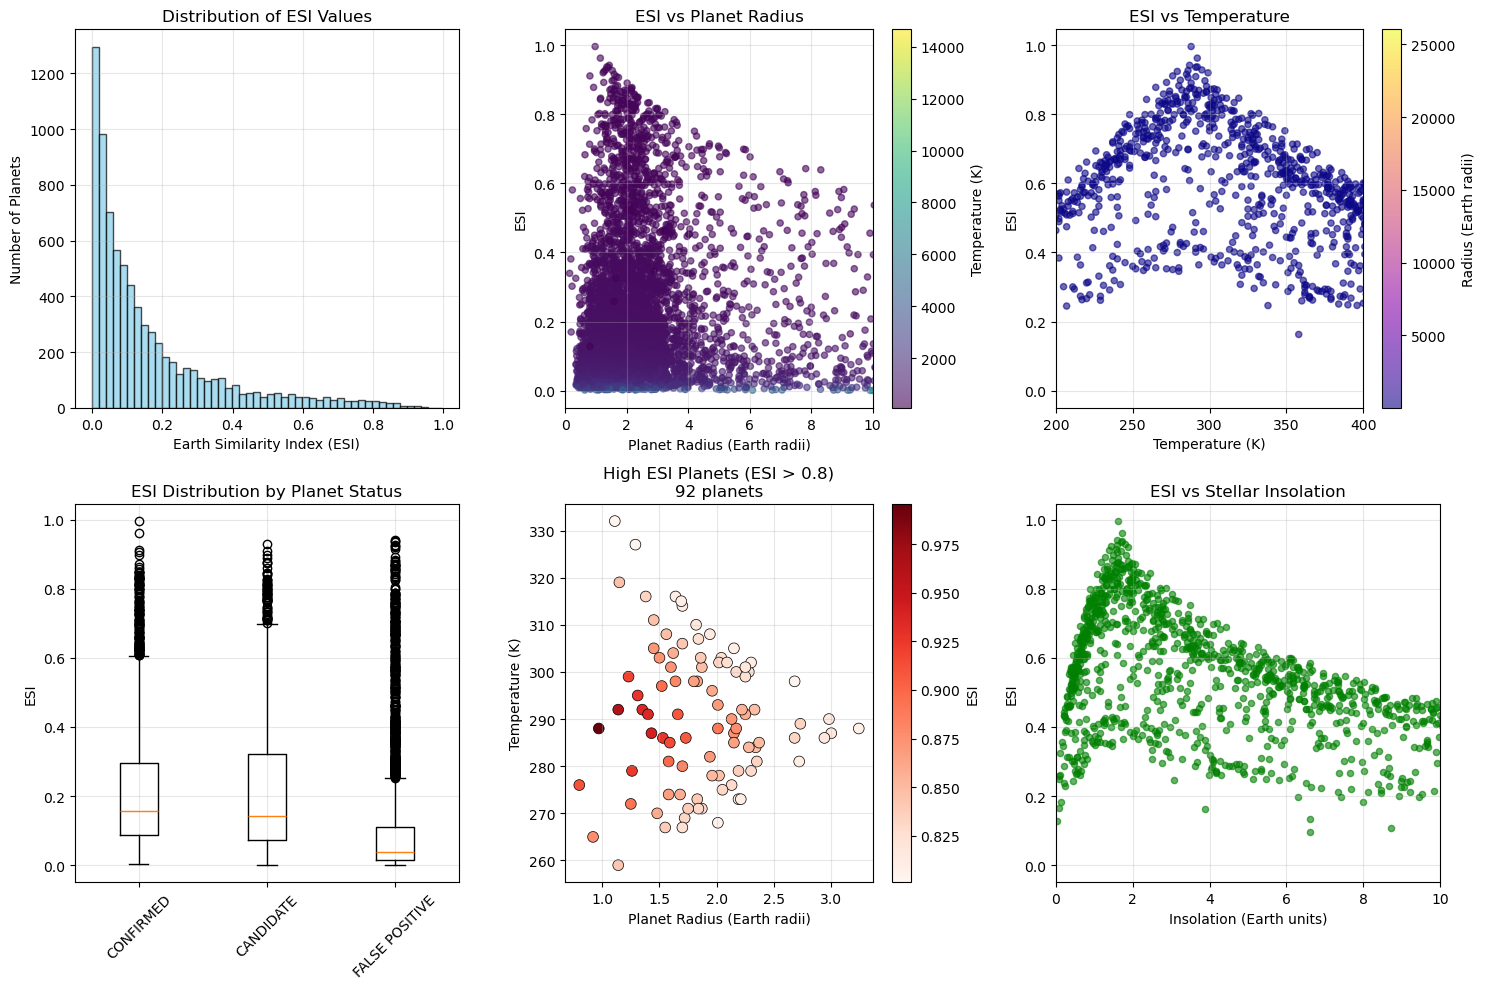


Summary of High ESI Planets (ESI > 0.8):
Total: 92
Confirmed: 35
Candidates: 24
False Positives: 33


In [23]:
# Create visualizations
plt.figure(figsize=(15, 10))

# 1. ESI distribution
plt.subplot(2, 3, 1)
plt.hist(df_full_esi['ESI'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Earth Similarity Index (ESI)')
plt.ylabel('Number of Planets')
plt.title('Distribution of ESI Values')
plt.grid(True, alpha=0.3)

# 2. ESI vs Planet Radius
plt.subplot(2, 3, 2)
plt.scatter(df_full_esi['koi_prad'], df_full_esi['ESI'], alpha=0.6, c=df_full_esi['koi_teq'], 
           cmap='viridis', s=20)
plt.xlabel('Planet Radius (Earth radii)')
plt.ylabel('ESI')
plt.title('ESI vs Planet Radius')
plt.xlim(0, 10)  # Focus on Earth-like sizes
plt.colorbar(label='Temperature (K)')
plt.grid(True, alpha=0.3)

# 3. ESI vs Temperature
plt.subplot(2, 3, 3)
plt.scatter(df_full_esi['koi_teq'], df_full_esi['ESI'], alpha=0.6, c=df_full_esi['koi_prad'], 
           cmap='plasma', s=20)
plt.xlabel('Temperature (K)')
plt.ylabel('ESI')
plt.title('ESI vs Temperature')
plt.xlim(200, 400)  # Focus on potentially habitable range
plt.colorbar(label='Radius (Earth radii)')
plt.grid(True, alpha=0.3)

# 4. ESI by disposition
plt.subplot(2, 3, 4)
dispositions = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
esi_by_disp = [df_full_esi[df_full_esi['koi_disposition'] == disp]['ESI'].values for disp in dispositions]
plt.boxplot(esi_by_disp, labels=dispositions)
plt.ylabel('ESI')
plt.title('ESI Distribution by Planet Status')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# 5. High ESI candidates (ESI > 0.8)
plt.subplot(2, 3, 5)
high_esi = df_full_esi[df_full_esi['ESI'] > 0.8]
plt.scatter(high_esi['koi_prad'], high_esi['koi_teq'], c=high_esi['ESI'], 
           cmap='Reds', s=60, edgecolors='black', linewidth=0.5)
plt.xlabel('Planet Radius (Earth radii)')
plt.ylabel('Temperature (K)')
plt.title(f'High ESI Planets (ESI > 0.8)\n{len(high_esi)} planets')
plt.colorbar(label='ESI')
plt.grid(True, alpha=0.3)

# 6. ESI vs Insolation
plt.subplot(2, 3, 6)
plt.scatter(df_full_esi['koi_insol'], df_full_esi['ESI'], alpha=0.6, s=20, color='green')
plt.xlabel('Insolation (Earth units)')
plt.ylabel('ESI')
plt.title('ESI vs Stellar Insolation')
plt.xlim(0, 10)  # Focus on Earth-like insolation
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nSummary of High ESI Planets (ESI > 0.8):")
print(f"Total: {len(high_esi)}")
print(f"Confirmed: {len(high_esi[high_esi['koi_disposition'] == 'CONFIRMED'])}")
print(f"Candidates: {len(high_esi[high_esi['koi_disposition'] == 'CANDIDATE'])}")
print(f"False Positives: {len(high_esi[high_esi['koi_disposition'] == 'FALSE POSITIVE'])}")

In [24]:
# Detailed analysis of the most promising Earth-like candidates
print("=== EARTH-LIKE EXOPLANET ANALYSIS ===\n")

# Filter for confirmed planets with high ESI
earth_like = df_full_esi[
    (df_full_esi['ESI'] > 0.7) & 
    (df_full_esi['koi_disposition'] == 'CONFIRMED')
].copy()

print(f"Confirmed planets with ESI > 0.7: {len(earth_like)}")

# Sort by ESI
earth_like_sorted = earth_like.sort_values('ESI', ascending=False)

print("\nTop 15 Most Earth-like CONFIRMED Exoplanets:")
print("=" * 80)
cols_to_show = ['kepoi_name', 'koi_prad', 'koi_teq', 'koi_period', 'koi_insol', 'ESI']
for i, (idx, planet) in enumerate(earth_like_sorted.head(15).iterrows(), 1):
    print(f"{i:2d}. {planet['kepoi_name']:10s} | "
          f"R={planet['koi_prad']:4.2f}R⊕ | "
          f"T={planet['koi_teq']:3.0f}K | "
          f"P={planet['koi_period']:6.1f}d | "
          f"Flux={planet['koi_insol']:6.1f}F⊕ | "
          f"ESI={planet['ESI']:5.3f}")

# Habitability criteria analysis
print("\n=== HABITABILITY ANALYSIS ===")
habitable_zone = df_full_esi[
    (df_full_esi['koi_teq'] >= 273) &  # Above freezing
    (df_full_esi['koi_teq'] <= 373) &  # Below boiling
    (df_full_esi['koi_prad'] >= 0.5) & # Not too small
    (df_full_esi['koi_prad'] <= 2.0) & # Not too large (super-Earth limit)
    (df_full_esi['koi_disposition'] == 'CONFIRMED')
]

print(f"Confirmed planets in habitable zone (273K < T < 373K, 0.5 < R < 2.0 R⊕): {len(habitable_zone)}")

if len(habitable_zone) > 0:
    print(f"Average ESI of habitable zone planets: {habitable_zone['ESI'].mean():.3f}")
    print(f"Best ESI in habitable zone: {habitable_zone['ESI'].max():.3f}")
    
    print("\nMost promising habitable candidates:")
    hz_sorted = habitable_zone.sort_values('ESI', ascending=False).head(5)
    for i, (idx, planet) in enumerate(hz_sorted.iterrows(), 1):
        print(f"{i}. {planet['kepoi_name']} - ESI: {planet['ESI']:.3f}, "
              f"R: {planet['koi_prad']:.2f}R⊕, T: {planet['koi_teq']:.0f}K")

# Save results to CSV for backend integration
df_full_esi.to_csv('kepler_with_esi.csv', index=False)
print(f"\n✓ Results saved to 'kepler_with_esi.csv' with {len(df_full_esi)} analyzed planets")
print(f"✓ Ready for backend integration via /api/analytics endpoints")

=== EARTH-LIKE EXOPLANET ANALYSIS ===

Confirmed planets with ESI > 0.7: 76

Top 15 Most Earth-like CONFIRMED Exoplanets:
 1. K03284.01  | R=0.97R⊕ | T=288K | P=  35.2d | Flux=   1.6F⊕ | ESI=0.996
 2. K02650.01  | R=1.14R⊕ | T=292K | P=  35.0d | Flux=   1.7F⊕ | ESI=0.962
 3. K03497.01  | R=0.80R⊕ | T=276K | P=  20.4d | Flux=   1.4F⊕ | ESI=0.911
 4. K00172.02  | R=1.73R⊕ | T=286K | P= 242.5d | Flux=   1.6F⊕ | ESI=0.906
 5. K01422.02  | R=1.52R⊕ | T=297K | P=  19.9d | Flux=   1.8F⊕ | ESI=0.897
 6. K02162.02  | R=1.45R⊕ | T=305K | P= 199.7d | Flux=   2.1F⊕ | ESI=0.870
 7. K00947.01  | R=1.83R⊕ | T=298K | P=  28.6d | Flux=   1.9F⊕ | ESI=0.863
 8. K04005.01  | R=2.25R⊕ | T=291K | P= 178.1d | Flux=   1.7F⊕ | ESI=0.858
 9. K04450.01  | R=2.33R⊕ | T=292K | P= 196.4d | Flux=   1.7F⊕ | ESI=0.848
10. K01078.03  | R=1.87R⊕ | T=301K | P=  28.5d | Flux=   1.9F⊕ | ESI=0.848
11. K03255.01  | R=1.56R⊕ | T=308K | P=  66.7d | Flux=   2.1F⊕ | ESI=0.847
12. K02469.01  | R=2.34R⊕ | T=284K | P= 131.2d | Flux